In [1]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation

import numpy as np
from scipy import integrate
from numba import jit
from tqdm import tqdm
import time

# B-field Solver by Biot Savart Law

In [2]:
class B_field_Solver(object):
    
    def __init__(self, object):
        """ Initiate the solver with the important paramaters depending on the object
        
        Parameters
        ----------
        self.vect_dL : np.ndarray
            sequence of vectors along the wire
        self.mid_point_dL : np.ndarray
            reference point for each self.vect_dL
        """
        
        self.current = object.I
        self.curve = object.coordz.T
        
        self.vect_dL = self.curve_dSegment_vector(self.curve)
        self.mid_point_dL = self.curve_dSegment_midpoint(self.curve)
        
        return
    
    def curve_dSegment_vector(self, curve):
        """ Convert a discretize curve define with point in the sequences of vector that constitute the curve
        
        Parameters
        ----------
        curve : np.ndarray of shape (n,3)
            sequence of points

        Returns
        -------
        vect_dSegment : np.ndarray
            sequence of vectors
        """
        vect_dSegment = np.diff(curve, axis=0)
        
        return vect_dSegment


    def curve_dSegment_midpoint(self, curve):
        """ Take a discretize curve and return the midpoint of each segment that constitute the curve
    
        Parameters
        ----------
        curve : np.ndarray of shape (n,3)
            sequence of points
    
        Returns
        -------
        mid_point_dSegment : np.ndarray
        sequence of midpoints
        """
        mid_point_dSegment = (curve[:-1] + curve[1:])/2
    
        return mid_point_dSegment
    
    def Solve_B_field_at_a_point(self, point): 
        """ Solves B field at a given point
    
        Parameters
        ----------    
        point : np.ndarray

        Returns
        -------
        B_field : np.ndarray
            B-field for at the given point
        """
        
        #vector from the infinitesimal displacement vector along the wire to the data point
        vect_r = point - self.mid_point_dL
    
        dB = self.solve_dB(vect_r)
        B_field = np.sum(dB, axis=0)
    
        return B_field
    
    def solve_dB(self, vect_r):
        """ Solves dB according to Biot Savart
    
        Parameters
        ----------    
        vect_r : np.ndarray
            sequence of vectors from the data point to the reference point on the wire

        Returns
        -------
        dB : np.ndarray of shape (n,3)
            infinitesimal B-field for each reference point
        """
        norm_r3 = np.linalg.norm(vect_r, axis=1)**3
        vect_dL_cross_vect_r = np.cross(self.vect_dL, vect_r)
        
        dB = self.current*(vect_dL_cross_vect_r.T/norm_r3).T
        
        return dB
    
    def Solve_B_field_for_data_points(self, data):
        """ Solves B field for a set of data point
    
        Parameters
        ----------    
        data : np.ndarray

        Returns
        -------
        B_field : np.ndarray of shape (n,3)
            B-field at each data points
        """
        B_field = np.apply_along_axis(self.Solve_B_field_at_a_point, axis=1, arr=data)
        return B_field

In [3]:
class Wire:
    '''
    Implements an arbitrary shaped wire
    '''
    #coordz = np.array([])
    '''Coordinates of the vertex of the wire in the form [X,Y,Z]'''
    #I = 1
    '''Complex current carried by the wire'''

    def __init__(self):
        '''
        By default initited nothing
        '''
        return

    def Set_Current(self, current):
        '''Sets current in wire'''
        self.I = current
        return

    def Create_Toroidal_Coil(self, R1, R2, N, step):
        '''
        Create_Toroidal_Coil( R1 , R2 , N , step )
        Creates a toroidal coil of major radius R1, minor radius R2 with N
         turns and a step step
         Initiates coordz
        '''
        a = R1
        b = R2
        c = N

        t = np.r_[0:2 * np.pi:step]

        X = (a + b * np.sin(c * t)) * np.cos(t);
        Y = (a + b * np.sin(c * t)) * np.sin(t);
        Z = b * np.cos(c * t);

        self.coordz = np.array([X, Y, Z])

        return

    def Create_Solenoid(self, R, N, l, step):
        '''
        Create_Solenoid(self, R , N , l , step )
        Creates a solenoid whose length is l with radius R, N turns with step
        step along the z axis
        '''
        a = R;
        b = l / (2 * np.pi * N);
        T = l / b;

        t = np.r_[0:T:step]

        X = a * np.cos(t);
        Y = a * np.sin(t);
        Z = b * t;
        
        self.coordz = np.array([X, Y, Z])
        
        return

    def Create_Loop(self, center, radius, NOP, theta, Orientation='xy'):
        '''
        Create_Loop(self,center,radius,NOP)
        a circle with center defined as
        a vector CENTER, radius as a scaler RADIS. NOP is 
        the number of points on the circle.
        '''
        t = np.linspace(0, 2 * np.pi, NOP)

        if Orientation == 'xy':
            X = center[0] + radius * np.sin(t)
            Y = center[1] + radius * np.cos(t)
            Z = np.zeros(NOP)
        elif Orientation == 'xz':
            X = center[0] + radius * np.sin(t)
            Z = center[1] + radius * np.cos(t)
            Y = np.zeros(NOP)
        elif Orientation == 'yz':
            Y = center[0] + radius * np.sin(t)
            Z = center[1] + radius * np.cos(t)
            X = np.zeros(NOP)
        
        XYZ_add = self.Rotation_Z(np.array([X, Y, Z]), theta)
        
        try:
            self.coordz
        except AttributeError:
            self.coordz = XYZ_add
        else:
            XYZ = self.coordz
            self.coordz = np.concatenate((XYZ, XYZ_add), axis=1)
        
        return
    
    def Create_D_Shape_coil(self, theta):
        
        def create_d_shaped_coil(r_in, r_out, x_in):
            #returns 1 branch of the d shaped electromagnetic coil with set inner and outer radii
            #https://lss.fnal.gov/conf/C720919/p240.pdf

            k = np.log(r_out/r_in)

            def d_coil_func(x):
                return(2*np.log(x)/(((k**2)-4*(np.log(x)**2))**0.5))

            def calculate_y(x):
                return integrate.quad(d_coil_func, r_in, x)

            vect_y = np.vectorize(calculate_y)
            return vect_y(x_in)[0]
        
        def Rotation_Z(theta):
            return np.array([[np.cos(theta), -np.sin(theta), 0],
                             [np.sin(theta), np.cos(theta), 0],
                             [0, 0, 1]])
        
        x = np.linspace(0.5,2,1000)
        z = create_d_shaped_coil(1,4, x)

        X = np.concatenate((x,np.flip(x),np.zeros(100)+0.5))
        Z = np.concatenate((-z+2*z[-1],np.flip(z),np.linspace(z[0],-z[0]+2*z[-1],100))) - max(z)
        Y = np.zeros(len(X))
        
        self.coordz = Rotation_Z(theta) @ np.array([X,Y,Z])
        
        return
        
    
    def Transform_Shift(self, x_shift, y_shift, z_shift):
        
        X = self.coordz[0] + x_shift
        Y = self.coordz[1] + y_shift
        Z = self.coordz[2] + z_shift
        
        self.coordz = np.array([X, Y, Z])
        
        return
    
    def Rotation_Z(self, vect, theta):
        rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                    [np.sin(theta), np.cos(theta), 0],
                                    [0, 0, 1]])
        return rotation_matrix @ vect

In [4]:
class Particle_Path_Solver(object):
    
    def __init__(self, object):
        self.charge = object[0]
        self.mass = 1
        
        self.B_field_Solver_for_object = []
        for myWire in object[1:]:
            self.B_field_Solver_for_object.append(B_field_Solver(myWire))
        return
    
    def acceleration_in_B_field(self, x, v):
        """ Acceleration in B-field due to Lorentz Force
        
        Parameters
        ----------
        x : np.ndarray
            position
        v : np.ndarray
            velocity 
        
        Returns
        -------
        a : np.ndarray
            acceleration
        """
        
        B_field_at_x_in_object = []
        for Solver in self.B_field_Solver_for_object:
            B_field_at_x_in_object.append(Solver.Solve_B_field_at_a_point(x))
        
        B_field_at_x = np.sum(B_field_at_x_in_object, axis=0)
        
        F = self.charge * np.cross(v, B_field_at_x)
        
        return F / self.mass
    
    
    def rk4(self, x0, v0, dt):
        """ Runge-kutta.

        Parameters
        ----------
        x0 : np.ndarray
            position 
        v0 : np.ndarray
            velocity 
        dt : float
            time step
        
        Returns
        -------
        x : np.ndarray, v : np.ndarray
        
        Source
        ------
        http://doswa.com/2009/01/02/fourth-order-runge-kutta-numerical-integration.html
        """
        a0 = self.acceleration_in_B_field(x0, v0)
        
        x1 = x0 + 0.5 * v0 * dt
        v1 = v0 + 0.5 * a0 * dt
        a1 = self.acceleration_in_B_field(x1, v1)
        
        x2 = x0 + 0.5 * v1 * dt
        v2 = v0 + 0.5 * a1 * dt
        a2 = self.acceleration_in_B_field(x2, v2)
        
        x3 = x0 + v2 * dt
        v3 = v0 + a2 * dt
        a3 = self.acceleration_in_B_field(x3, v3)
        
        x4 = x0 + (dt / 6) * (v0 + 2*v1 + 2*v2 + v3)
        v4 = v0 + (dt / 6) * (a0 + 2*a1 + 2*a2 + a3)
        
        return x4, v4
    
    
    def trajectory(self, t0, x0, v0, dt, max_iterations):
        """ step-by-step 3D particle trajectory
        
        Parameters
        ----------
        t0 : float
            initial time
        x0 : np.ndarray
            initial position 
        v0 : np.ndarray
            initial velocity 
        dt : float
            time step
        max_iterations : int
            number of steps
        
        Returns
        -------
        np.array([['time', 'x', 'y', 'z']])
        """
        # initialise
        i = 1
        t = t0
        x = np.array(x0)
        v = np.array(v0)
        result = [[t, x[0], x[1], x[2]]]
        
        # step-by-step trajectory
        while i < max_iterations:
            x, v = self.rk4(x, v, dt)
            t += dt
            
            
            # If the particle escapes from the inside of tore, cease calculations
            distance_xy = np.linalg.norm(x[:2])
            distance_z = x[2]
            if (distance_xy > 1.5) or (distance_xy < 0) or (distance_z > 0.5):
                print('collision')
                break
            
            
            # record
            result.append([t, x[0], x[1], x[2]])
            # next step
            i += 1
        
        # output
        return np.array(result)

## Toroidal Field Coils

In [5]:
myToroidal = Wire()

#Toroidal of major radius R1 and minor radius R2
R1_Toroidal = 1
R2_Toroidal = 0.5
N_Toroidal = 20
step_Toroidal = 0.001

myToroidal.Create_Toroidal_Coil(R1_Toroidal, R2_Toroidal, N_Toroidal, step_Toroidal)
myToroidal.Set_Current(1)

## Plasma Current

In [6]:
myPlasma = Wire()

#Plasma of radius R in the xy plane
C_Plasma = [0,0]
R_Plasma = 1
step_Plasma = 100

myPlasma.Create_Loop(C_Plasma, R_Plasma, step_Plasma, 0, 'xy')
myPlasma.Set_Current(-1)

# Tokamak Solve Magnetic Field for each Coils

In [7]:
#Points on which we find the magnetic field
myData = Wire();
for i in range(1):
    myData.Create_Loop([1,0],0.5/4,9,i*np.pi/6,'xz')
Data_Points = myData.coordz.T

## Toroidal Magnetic Field

In [8]:
B_field_Solver_Toroidal = B_field_Solver(myToroidal)
B_Toroidal = B_field_Solver_Toroidal.Solve_B_field_for_data_points(Data_Points)

## Plasma Magnetic Field

In [9]:
myPlasma.Set_Current(-5)
B_field_Solver_Plasma = B_field_Solver(myPlasma)
B_Plasma = B_field_Solver_Plasma.Solve_B_field_for_data_points(Data_Points)

## Plot Tokamak Magnetic Field

In [10]:
B_Total = B_Toroidal + B_Plasma

C:\Users\polol\AppData\Local\Temp\ipykernel_15440\556308409.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


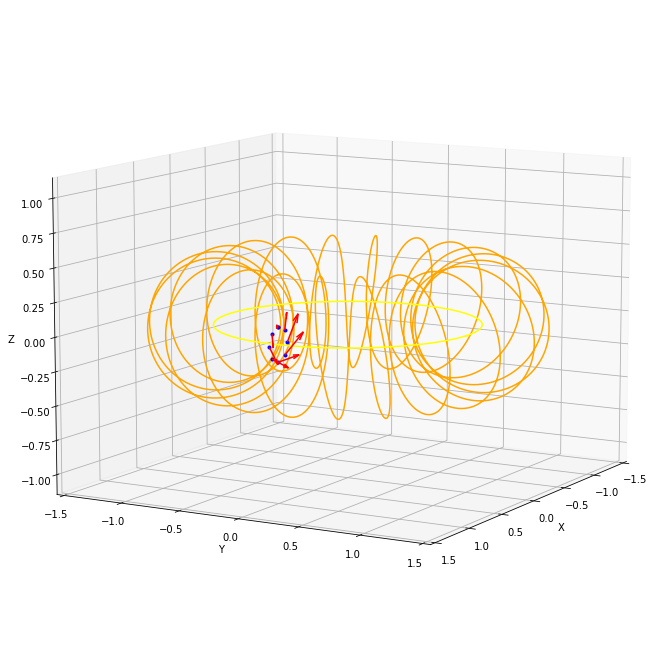

In [11]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')
ax.view_init(elev=10, azim=30)

ax.plot(*myToroidal.coordz, color='orange')
ax.plot(*Data_Points.T, '.', color='blue')
ax.plot3D(*myPlasma.coordz, color='yellow')
ax.quiver3D(*Data_Points.T,*np.transpose(B_Total)/500, color='r', normalize=False)

ax.set_xlim(-1.5,1.5)
ax.set_xlabel('X')

ax.set_ylim(-1.5,1.5)
ax.set_ylabel('Y')

ax.set_zlim(-1.1,1.1)
ax.set_zlabel('Z')

plt.show()

# B-field in solenoid

In [12]:
#Points on which we find the magnetic field
myData_Solenoid = Wire();
for i in range(10):
    for j in range(5):
        myData_Solenoid.Create_Loop([0,0],j/6/3,20,0,'xy')
    myData_Solenoid.Transform_Shift(0, 0, -0.1)
myData_Solenoid.Transform_Shift(0, 0, 0.5)
data_field_solenoid = myData_Solenoid.coordz.T

In [13]:
mySolenoid = Wire()

R_Solenoid = 0.375
N_Solenoid = 10
l_Solenoid = 1
step_Solenoid = 0.1

mySolenoid.Create_Solenoid(R_Solenoid, N_Solenoid, l_Solenoid, step_Solenoid)
mySolenoid.Transform_Shift(0, 0, -0.5)
mySolenoid.Set_Current(1)

B_field_Solver_Solenoid = B_field_Solver(mySolenoid)
B_Solenoid = B_field_Solver_Solenoid.Solve_B_field_for_data_points(data_field_solenoid)

C:\Users\polol\AppData\Local\Temp\ipykernel_15440\520243636.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


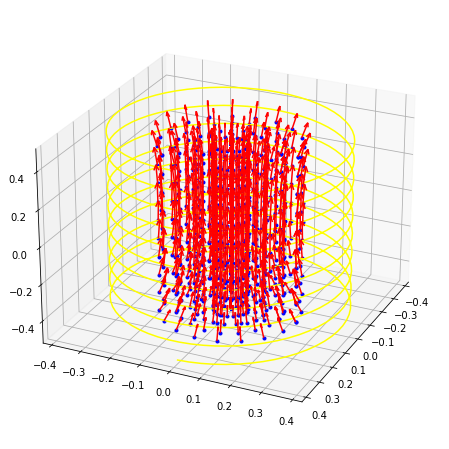

In [14]:
fig = plt.figure(figsize=[12,8])
ax = fig.gca(projection='3d')
ax.view_init(elev=25, azim=25)

ax.plot(*data_field_solenoid.T, '.', color='blue')
ax.plot(*mySolenoid.coordz, color='yellow')
ax.quiver3D(*data_field_solenoid.T,*np.transpose(B_Solenoid)/1000, color='r', normalize=False)

plt.show()

## Traj in solenoid

In [15]:
x0 = np.array([-0.125, 0.0, 0.0])
v0 = np.array([0.0, 5.0, 1.0])
mySolenoid.Set_Current(1)

Particle_Path_Solver_Solenoid = Particle_Path_Solver([mySolenoid])
tr = Particle_Path_Solver_Solenoid.trajectory(0.0, x0, v0, dt=0.005, max_iterations=int(2e2))

AxisError: axisb: axis -1 is out of bounds for array of dimension 0

In [ ]:
fig = plt.figure(figsize=[12,8])
ax = fig.gca(projection='3d')
ax.view_init(elev=20, azim=30)

length = len(tr.T[0])
nrm = mpl.colors.Normalize(0,length)
colors = mpl.cm.cool(nrm(range(length)))

ax.scatter(*tr.T[1:], '.', color=colors)
ax.plot(*mySolenoid.coordz, color='blue')
#ax.quiver3D(*data_field_solenoid.T,*np.transpose(B_Solenoid)/1000, color='r', normalize=False)

plt.show()

## Traj in Tokamak without plasma current field

In [23]:
myToroidal.Set_Current(0.1)
x0 = np.array([1.1, 0.0, 0.0])
v0 = np.array([0.0, 1.0, 0.0])

In [17]:
myToroidal.Set_Current(5)
x0 = np.array([1.1, 0.0, 0.0])
v0 = np.array([0.0, 5.0, 0.0])

In [18]:
Particle_Path_Solver_Toroidal = Particle_Path_Solver([-1, myToroidal])
tr = Particle_Path_Solver_Toroidal.trajectory(0.0, x0, v0, dt=0.005, max_iterations=int(2e3))

C:\Users\polol\AppData\Local\Temp\ipykernel_15440\4147401999.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


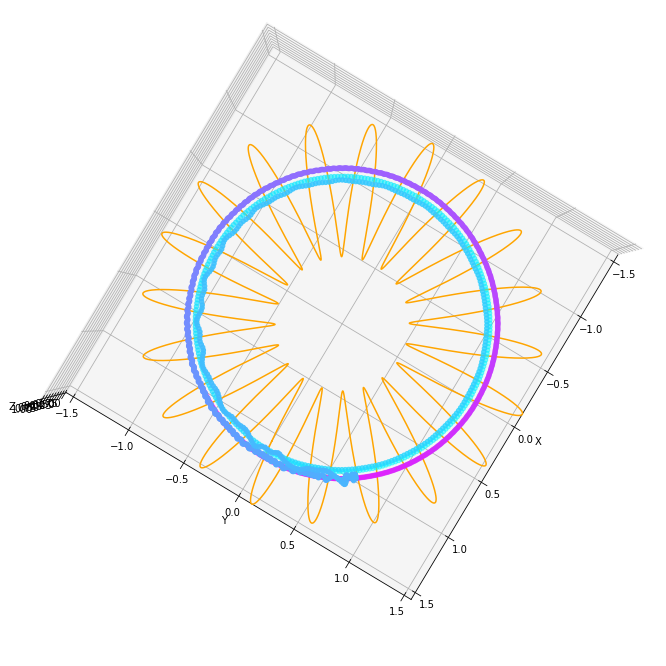

In [19]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')
ax.view_init(elev=90, azim=30)


length = len(tr.T[0])
nrm = mpl.colors.Normalize(0,length)
colors = mpl.cm.cool(nrm(range(length)))
ax.scatter(*tr.T[1:], '.', color=colors)

ax.plot3D(*myToroidal.coordz, color='orange')
#ax.plot3D(*myPlasma.coordz, color='yellow')

# Setting the axes properties
ax.set_xlim(-1.5,1.5)
ax.set_xlabel('X')

ax.set_ylim(-1.5,1.5)
ax.set_ylabel('Y')

ax.set_zlim(-1.1,1.1)
ax.set_zlabel('Z')

plt.show()

## Traj in Tokamak with plasma current field

In [20]:
myToroidal.Set_Current(5)
myPlasma.Set_Current(-5)
x0 = np.array([1.1, 0.0, 0.0])
v0 = np.array([0.0, 5.0, 0.0])

Particle_Path_Solver_Toroidal = Particle_Path_Solver([-1, myToroidal, myPlasma])
tr = Particle_Path_Solver_Toroidal.trajectory(0.0, x0, v0, dt=0.005, max_iterations=int(4e3))

C:\Users\polol\AppData\Local\Temp\ipykernel_15440\2906018276.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


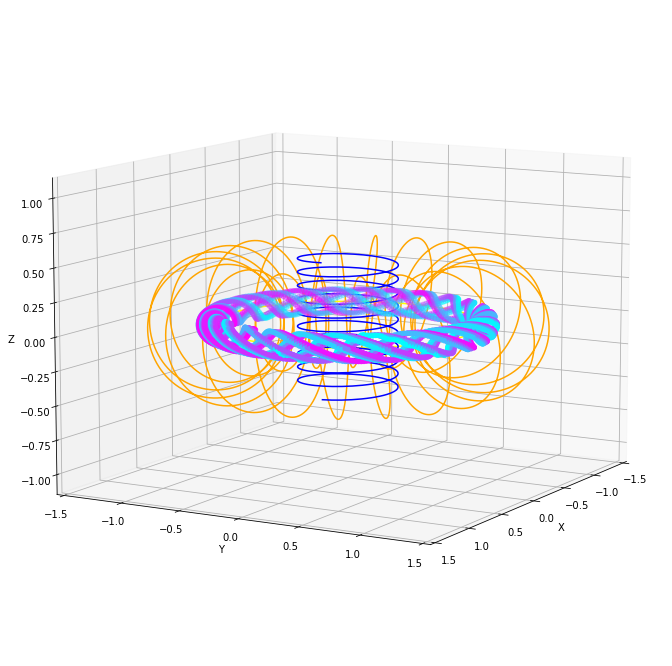

In [21]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')
ax.view_init(elev=10, azim=30)

length = len(tr.T[0])
nrm = mpl.colors.Normalize(0,length)
colors = mpl.cm.cool(nrm(range(length)))
ax.scatter(*tr.T[1:], '.', color=colors)

ax.plot3D(*myToroidal.coordz, color='orange')
ax.plot3D(*myPlasma.coordz, color='yellow')
ax.plot3D(*mySolenoid.coordz, color='blue')

# Setting the axes properties
ax.set_xlim(-1.5,1.5)
ax.set_xlabel('X')

ax.set_ylim(-1.5,1.5)
ax.set_ylabel('Y')

ax.set_zlim(-1.1,1.1)
ax.set_zlabel('Z')

plt.show()

## Anim plot

C:\Users\polol\AppData\Local\Temp\ipykernel_15440\2619863730.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')
MovieWriter imagemagick unavailable; using Pillow instead.


KeyboardInterrupt: 

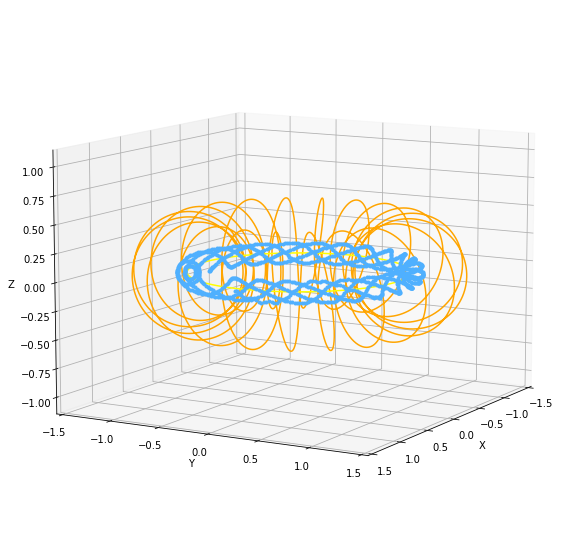

In [22]:
#%matplotlib notebook

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.view_init(elev=10, azim=30)

ax.plot3D(*myToroidal.coordz, color='orange')
ax.plot3D(*myPlasma.coordz, color='yellow')

def update(num, data, line):
    line.set_data(data[:2, :num])
    line.set_3d_properties(data[2, :num])
    line.set_color(colors[num])

length = len(tr.T[0])
nrm = mpl.colors.Normalize(0,length)
colors = mpl.cm.cool(nrm(range(length)))

data = tr.T[1:]
line, = ax.plot3D(data[0, 0:1], data[1, 0:1], data[2, 0:1], '.', color=colors[0])

# Setting the axes properties
ax.set_xlim(-1.5,1.5)
ax.set_xlabel('X')

ax.set_ylim(-1.5,1.5)
ax.set_ylabel('Y')

ax.set_zlim(-1.1,1.1)
ax.set_zlabel('Z')

anim = animation.FuncAnimation(fig, update, length, fargs=(data, line), interval=20, blit=False)
anim.save('particle.gif', writer='imagemagick')

plt.show()

# Transform a solenoid to a toroid

In [ ]:
%matplotlib notebook

fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection='3d')
ax.view_init(elev=90, azim=30)

def gen_deformation(n):
    R = np.pi/np.linspace(0.01,np.pi,n)
    for a in R:
        c = 20*a
        b = 0.5
        t = np.linspace(-np.pi/a,np.pi/a,1000)
        X = ((a + b * np.sin(c * t)) * np.cos(t)-a)+1
        Y = ((a + b * np.sin(c * t)) * np.sin(t))
        Z = (b * np.cos(c * t))
        yield np.array([X,Y,Z])

N = 50
data = np.array(list(gen_deformation(N)))

def update(num):
    ax.clear()
    
    ax.plot(*data[num])
    
    ax.set_xlim(-2.65,0.65)
    ax.set_xlabel('X')
    
    ax.set_ylim(-1.65,1.65)
    ax.set_ylabel('Y')
    
    ax.set_zlim(-1.15,1.15)
    ax.set_zlabel('Z')

ax.plot(*data[-1])
#anim = animation.FuncAnimation(fig, update, N, interval=10000)
#anim.save('solenoid_to_toroidal.gif', writer='imagemagick', fps=50)

plt.show()